In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import ase
import numpy as np
import ase.io as aio

from toolz.curried import pipe, curry, compose

In [3]:
import plot
import atommks.helpers as utils
import atommks.atomstat as astat

In [4]:
# import filters
# import stats as astat
# import utilities as utils

In [4]:
import pyvista as pv
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [5]:
from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

## Estimate Distrubance in 3D

In our use of both two point statistics and rdf, we first extract atoms that constitute the substructure of interest (e.g. cascade or grain boundary) - then utilize either of these two metrics to aggregate the local environment around all the atoms constituting the substructure.

* Load coordinates of all atoms in 'coords_all'
* Load coordinates of disturbed atom in 'coords_sub' 
    * (They can be computed using ovito - Common Neighbour Analysis and saved in an xyz file )
* The xyz file if available can be read with ase usin the following code snippet:

         atom = aio.read("file_name.xyz")
         coords = atom.get_positions()

### When computing for damaged structures, atoms corresponding to the damaged region are considered.

In [6]:
cutoff = 17.0
r_stat = 15.0
len_pixel = 10.0

## Damaged Structure

In [9]:
%%time
ix=10
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

idx = np.where(atoms.get_tags() != 1)[0]
print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

if len(idx) == 0:
    np.random.seed(81396)
    idx = np.random.randint(low=0, high=len(atoms), size=2000)

coords_all = atoms.get_positions()
coords_sub = coords_all[idx]

try:
    obj = utils.load_file("data/stat_indxs_cutoff_150/dump.arc.{}_stat.pkl".format(runs[ix]))
    indexes = obj["indexes"]
except Exception as err:
    
    tree = astat.get_kdTree(atoms.get_positions(), 
              cell_dim=atoms.get_cell_lengths_and_angles(), 
             cutoff=cutoff 
             )

    indexes = tree.search_tree(coords_sub, radius=r_stat)

total atoms: 4000000, disturbed atoms: 244316
CPU times: user 11.3 s, sys: 3.57 s, total: 14.8 s
Wall time: 5.98 s


In [10]:
%%time
ix=10
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

idx = np.where(atoms.get_tags() != 1)[0]
print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

if len(idx) == 0:
    np.random.seed(81396)
    idx = np.random.randint(low=0, high=len(atoms), size=2000)

coords_sub = coords_all[idx]

tree = astat.get_kdTree(coords_sub, 
                        cell_dim=atoms.get_cell_lengths_and_angles(), 
                        cutoff=cutoff)

indexes = tree.search_tree(coords_sub, radius=r_stat)

total atoms: 4000000, disturbed atoms: 244316
CPU times: user 2min 58s, sys: 6.8 s, total: 3min 5s
Wall time: 2min 51s


## load real space stat coordinates

In [11]:
%%time
coords_stat = astat.get_realStats(coords_sub, coords_sub, indexes, r_stat=r_stat, 
                                  cell=atoms.get_cell(), 
                                  pbc=atoms.get_pbc())

CPU times: user 22.4 s, sys: 2.78 s, total: 25.2 s
Wall time: 11.8 s


## Compute RDF

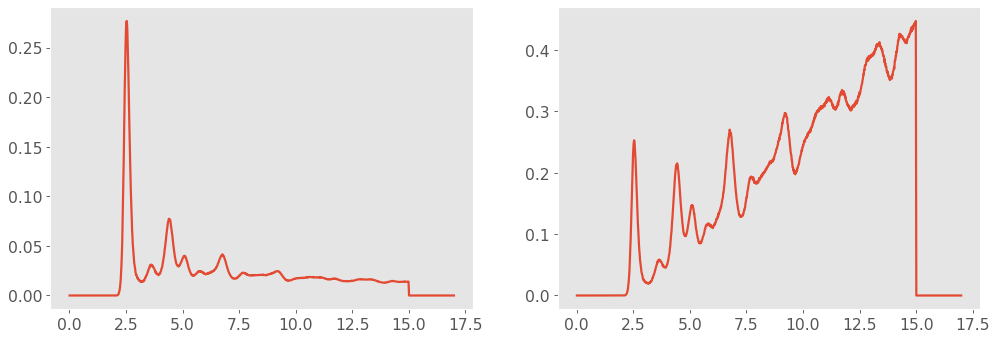

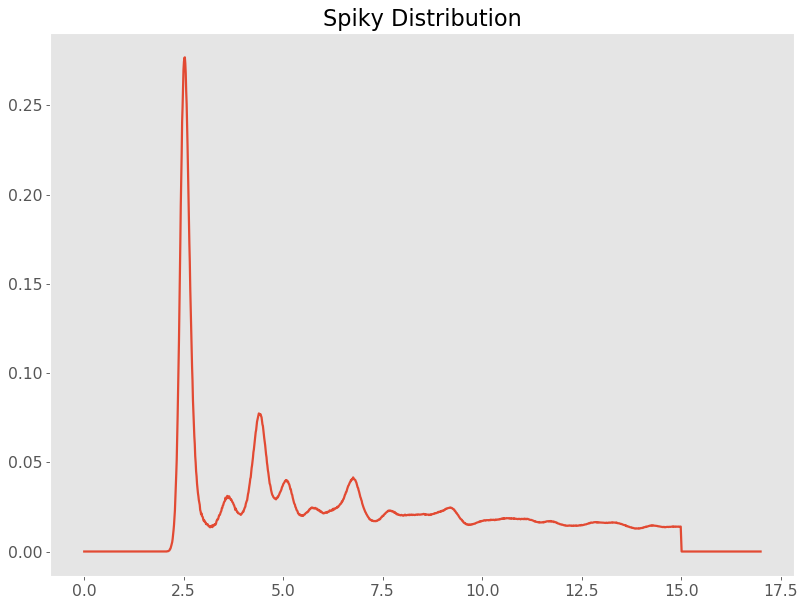

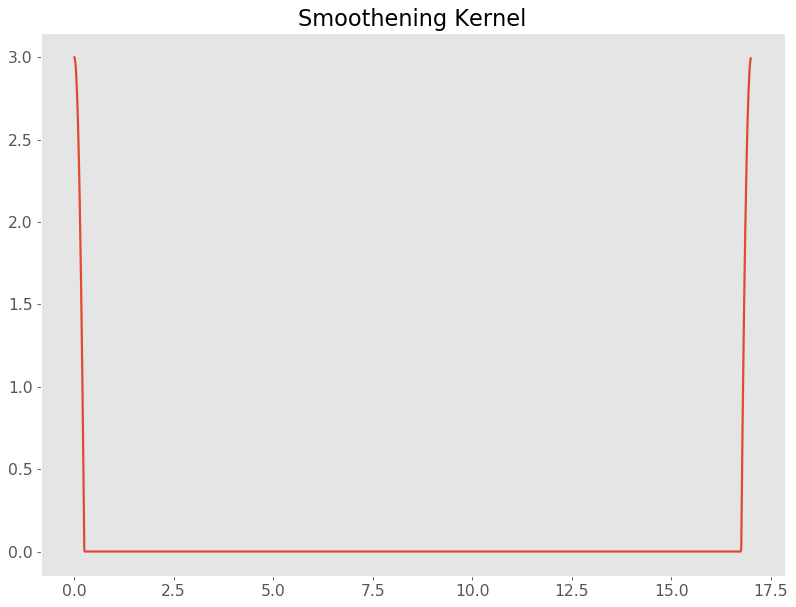

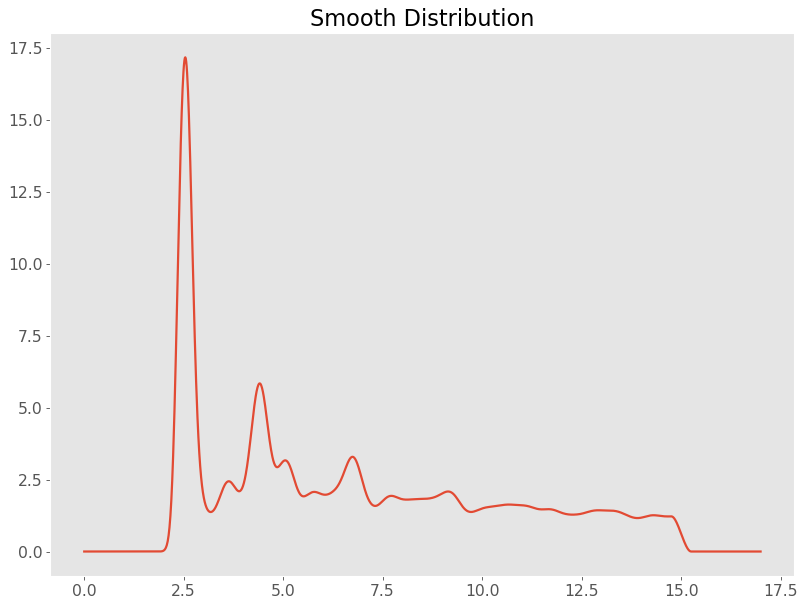

CPU times: user 14.7 s, sys: 949 ms, total: 15.6 s
Wall time: 8.14 s


In [12]:
%%time
rdf, pdf, bin_centers = astat.get_rdf(coords_stat, r_stat, len_pixel*10)

kernel = utils.epanechnikov_kernel(width=0.25, x=bin_centers)
smooth_pdf = utils.convolve_kernel(kernel, pdf)

plot.draw_1d_by_side(bin_centers, rdf, pdf)

plot.draw_1d(bin_centers, pdf, title="Spiky Distribution")
plot.draw_1d(bin_centers, kernel, title="Smoothening Kernel")
plot.draw_1d(bin_centers, smooth_pdf, title="Smooth Distribution")

### Compute the vector counts and save them in a matrix called box

In [13]:
%%time
box = astat.get_2ptStat(coords_stat, r_stat, len_pixel)
print("shape of the stat box: {}".format(box.shape))

/storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "atommks/atomstat.py", line 103:
@numba.njit(parallel=True)
def box_count(box, indexes, N, shape):
^

  self.func_ir.loc))


shape of the stat box: (301, 301, 301)
CPU times: user 10.3 s, sys: 1.8 s, total: 12.1 s
Wall time: 6.06 s


### Visualize the vector counts

In [ ]:
# point_cloud = pv.PolyData(coords_stat)
# point_cloud.plot(render_points_as_spheres=True)

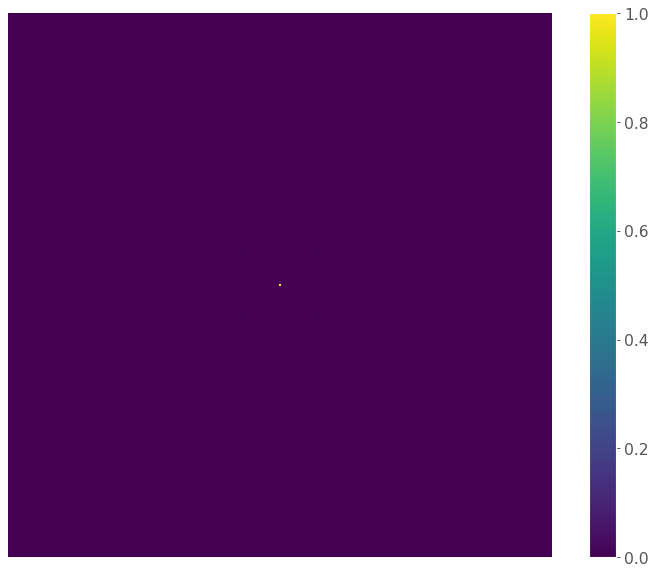

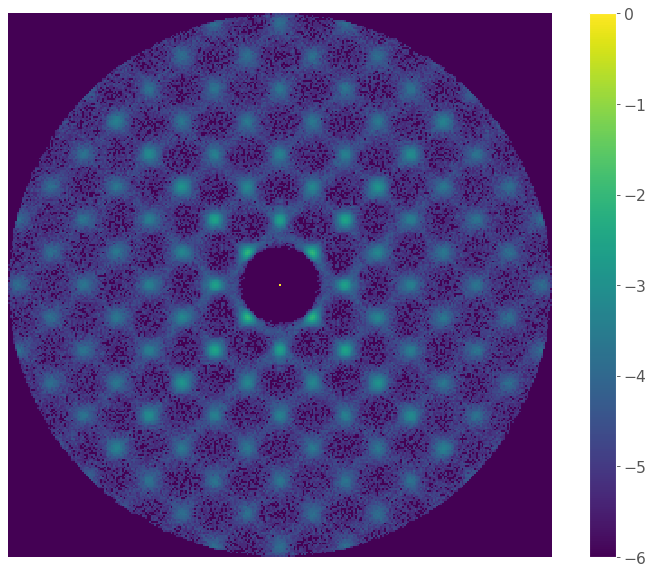

In [15]:
idx = int(r_stat * len_pixel) # index of center slice
plot.draw_2d(box[:,:, idx])
plot.draw_2d(np.log10(box[:,:,idx]+1e-6))

## Compute a smoothening filter for two point statistics

In [101]:
r_s = 1.0 # radius of the smoothening filter
new_shape = np.asarray(box.shape) + int(2 * r_s * len_pixel)

fs = pipe(r_s, 
          lambda r_s: utils.sphere(r_s * len_pixel),
          lambda s: utils.padder(s, new_shape),
          lambda s: utils.imfilter(f_data1=s, f_data2=s) / np.count_nonzero(s))

## Apply the smoothening filter to the box

In [102]:
%%time
box1 = pipe(box, 
            lambda s: utils.padder(s, new_shape), 
            lambda s: utils.imfilter(f_data1=s, f_data2=fs))

CPU times: user 11.4 s, sys: 1.68 s, total: 13.1 s
Wall time: 13.6 s


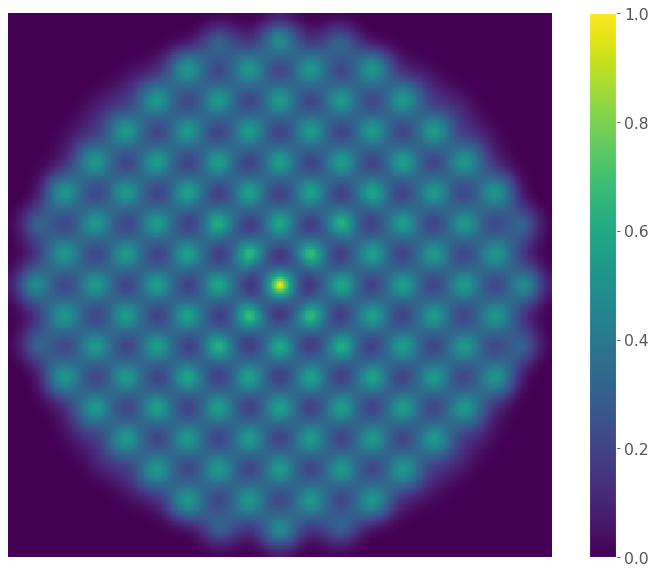

In [103]:
idx = int((r_stat + r_s) * len_pixel)
plot.draw_2d(box1[:,:,idx])

In [104]:
utils.write2vtk(matrix=box, fname="box0_damaged.vtk")
utils.write2vtk(matrix=box1, fname="box1_damaged.vtk")

In [94]:
# utils.write2vtk(matrix=box, fname="box0_perfect.vtk")
# utils.write2vtk(matrix=box1, fname="box1_perfect.vtk")

In [83]:
# utils.write2vtk(matrix=box, fname="box0_themalized.vtk")
# utils.write2vtk(matrix=box1, fname="box1_themalized.vtk")

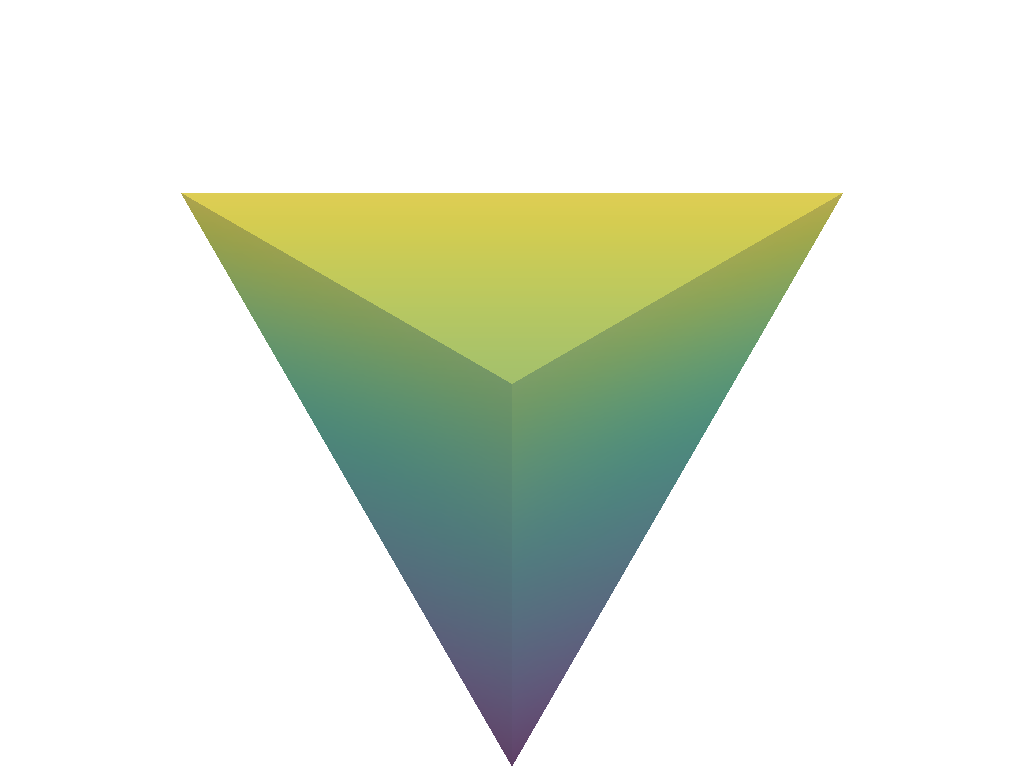

In [63]:
# x, y, z = mgrid[:301, :301, :301]
# grid = pv.StructuredGrid(x, y, z)
# grid["vol"] = box.flatten()
# contours = grid.contour([0.5])

# #%% Visualization
# pv.set_plot_theme('document')
# p = pv.Plotter()
# p.add_mesh(contours, scalars=contours.points[:, 2], show_scalar_bar=False, opacity=0.5)
# p.show()